# OPeNDAP Access


In [1]:
#https://ghrc.nsstc.nasa.gov/opendap/globalir/data/2020/0525/globir.20146.0000
from netCDF4 import Dataset
import xarray as xr
import dask
import os
import requests


#Allows us to visualize the dask progress for parallel operations
from dask.diagnostics import ProgressBar
ProgressBar().register()



In [2]:
import urllib
from urllib import request
from http.cookiejar import CookieJar
import json
from urllib import request, parse
from http.cookiejar import CookieJar
import getpass
import netrc



def get_token( url: str,client_id: str, user_ip: str,endpoint: str) -> str:
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
        token: str = ''
        xml: str = """<?xml version='1.0' encoding='utf-8'?>
        <token><username>{}</username><password>{}</password><client_id>{}</client_id>
        <user_ip_address>{}</user_ip_address></token>""".format(username, password, client_id, user_ip)
        headers: Dict = {'Content-Type': 'application/xml','Accept': 'application/json'}
        resp = requests.post(url, headers=headers, data=xml)
        response_content: Dict = json.loads(resp.content)
        token = response_content['token']['id']
    except:
        print("Error getting the token - check user name and password")
    return token

def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file
    first and if no credentials are found, it prompts for them.
    Valid endpoints include:
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('Please provide your Earthdata Login credentials to allow data access')
        print('Your credentials will only be passed to %s and will not be exposed in Jupyter' % (endpoint))
        username = input('Username:')
        password = getpass.getpass()

    
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)

edl="urs.earthdata.nasa.gov"
cmr="cmr.earthdata.nasa.gov"

setup_earthdata_login_auth(edl)
token_url="https://"+cmr+"/legacy-services/rest/tokens"
token=get_token(token_url,'podaac-subscriber', "127.0.0.1",edl)

In [3]:
#CMR Link to use
#https://cmr.earthdata.nasa.gov/search/granules.umm_json?collection_concept_id=C1625128926-GHRC_CLOUD&temporal=2019-01-01T10:00:00Z,2019-12-31T23:59:59Z
r = requests.get('https://cmr.earthdata.nasa.gov/search/granules.umm_json?collection_concept_id=C1996881146-POCLOUD&temporal=2019-01-01T10:00:00Z,2019-02-01T00:00:00Z&pageSize=365&token='+ token)
response_body = r.json()

In [12]:
od_files = []
for itm in response_body['items']:
    for urls in itm['umm']['RelatedUrls']:
        if 'OPeNDAP' in urls['Description']:
            od_files.append(urls['URL'])

od_files
        

['https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1',
 'https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190102090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1',
 'https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190103090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1',
 'https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190104090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1',
 'https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/G

In [13]:
len(od_files)

32

In [ ]:
for f in od_files:
    print (" opening " + f)
    data_url = f'{f}.dap.nc4'
    
    
    # The notation below is [start index, step, end index]
    # lat[ /lat= 0..17998] start index. = -90
    # lon[ /lon= 0..35999] start index. = -180
    # time[ /time= 0..0] 
    required_variables = {'analysed_sst[0:1:0][000:1:9000][000:1:9000]',
                          'analysis_error[0:1:0][000:1:9000][000:1:9000]',
                          'lat[000:1:9000]',
                          'lon[000:1:9000]',
                         'time[0:1:0]'}

    #upper latitude, left longitude, lower latitude, right longitude

    basename = os.path.basename(data_url)
    request_params = {'dap4.ce': ';'.join(required_variables)}
    #identity encoding to work around an issue with server side response compression (??)
    response = requests.get(data_url, params=request_params,  headers={'Accept-Encoding': 'identity'})

    if response.ok:
        with open(basename, 'wb') as file_handler:
            file_handler.write(response.content)
    else:
        print(f'Request failed: {response.text}')



 opening https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1


In [18]:
import xarray as xr
cloud_data = xr.open_mfdataset('*.dap.nc4', engine='h5netcdf')

/Users/gangl/miniconda3/envs/notebooks/lib/python3.8/site-packages/h5netcdf/core.py:769: FutureWarning: String decoding changed with h5py >= 3.0. See https://docs.h5py.org/en/latest/strings.html for more details. Currently backwards compatibility with h5py < 3.0 is kept by decoding vlen strings per default. This will change in future versions for consistency with h5py >= 3.0. To silence this warning set kwarg ``decode_vlen_strings=False``. Setting ``decode_vlen_strings=True`` forces vlen string decoding.
  warnings.warn(msg, FutureWarning, stacklevel=0)
/Users/gangl/miniconda3/envs/notebooks/lib/python3.8/site-packages/h5netcdf/core.py:769: FutureWarning: String decoding changed with h5py >= 3.0. See https://docs.h5py.org/en/latest/strings.html for more details. Currently backwards compatibility with h5py < 3.0 is kept by decoding vlen strings per default. This will change in future versions for consistency with h5py >= 3.0. To silence this warning set kwarg ``decode_vlen_strings=False

/Users/gangl/miniconda3/envs/notebooks/lib/python3.8/site-packages/h5netcdf/core.py:769: FutureWarning: String decoding changed with h5py >= 3.0. See https://docs.h5py.org/en/latest/strings.html for more details. Currently backwards compatibility with h5py < 3.0 is kept by decoding vlen strings per default. This will change in future versions for consistency with h5py >= 3.0. To silence this warning set kwarg ``decode_vlen_strings=False``. Setting ``decode_vlen_strings=True`` forces vlen string decoding.
  warnings.warn(msg, FutureWarning, stacklevel=0)
/Users/gangl/miniconda3/envs/notebooks/lib/python3.8/site-packages/h5netcdf/core.py:769: FutureWarning: String decoding changed with h5py >= 3.0. See https://docs.h5py.org/en/latest/strings.html for more details. Currently backwards compatibility with h5py < 3.0 is kept by decoding vlen strings per default. This will change in future versions for consistency with h5py >= 3.0. To silence this warning set kwarg ``decode_vlen_strings=False

In [19]:
cloud_data

,Array,Chunk
Bytes,10.37 GB,324.07 MB
Shape,"(32, 9001, 9001)","(1, 9001, 9001)"
Count,96 Tasks,32 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,10.37 GB,324.07 MB
Shape,"(32, 9001, 9001)","(1, 9001, 9001)"
Count,96 Tasks,32 Chunks
Type,float32,numpy.ndarray


[########################################] | 100% Completed | 24.2s


(array([3.66360932e+08, 1.41879822e+08, 1.33084109e+08, 1.42820817e+08,
        1.34985851e+08, 1.21022644e+08, 1.70274605e+08, 3.11394382e+08,
        4.32103972e+08, 2.16985858e+08]),
 array([271.35   , 274.6785 , 278.00702, 281.3355 , 284.664  , 287.9925 ,
        291.321  , 294.6495 , 297.978  , 301.30652, 304.635  ],
       dtype=float32),
 <a list of 10 Patch objects>)

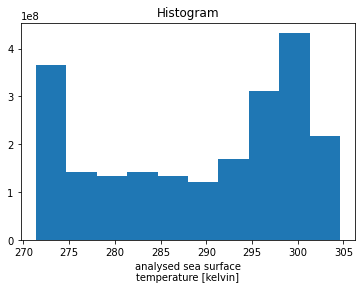

In [20]:
#Histogram
cloud_data['analysed_sst'].plot()


[########################################] | 100% Completed |  1.1s


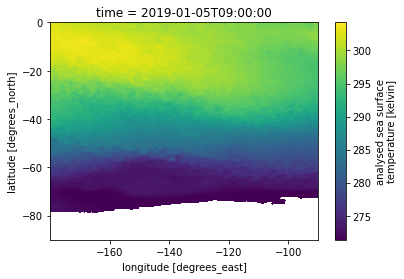

In [21]:
# Choose one time segment, plot the data
cloud_data['analysed_sst'].isel(time=4).plot()


[########################################] | 100% Completed |  0.5s


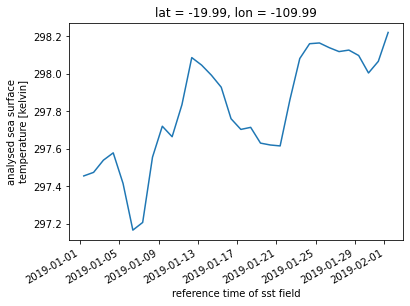

In [23]:
#Plot a single point over time
cloud_data['analysed_sst'].isel(lat=7000, lon=7000).plot()
